In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import math
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit as scf

In [2]:
df = pd.read_csv('Ca-Data-BrainZell.csv', index_col=0)
print(df.shape)
df.head()

(385, 720)


,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,...,Column716,Column717,Column718,Column719,Column720,Column721,Column722,Column723,Column724,Column725
Column5,,,,,,,,,,,,,,,,,,,,,
Well,0,1.05,1.58,2.09,2.63,3.14,3.67,4.19,4.72,5.23,...,378.48,379.02,379.55,380.08,380.61,381.16,381.69,382.23,382.77,383.3
A1,6286,6311.00,6305.00,6307.00,6320.00,6316.00,6333.00,6355.00,6348.00,6346.00,...,6915.00,6932.00,6933.00,6917.00,6928.00,6917.00,6950.00,6944.00,6956.00,6917.0
A2,6425,6492.00,6492.00,6478.00,6512.00,6494.00,6512.00,6513.00,6515.00,6539.00,...,7285.00,7279.00,7294.00,7276.00,7289.00,7285.00,7284.00,7305.00,7281.00,7299.0
A3,7635,7692.00,7710.00,7740.00,7758.00,7727.00,7757.00,7758.00,7744.00,7776.00,...,8074.00,8085.00,8074.00,8074.00,8056.00,8067.00,8094.00,8080.00,8062.00,8090.0
A4,7023,7051.00,7063.00,7098.00,7095.00,7104.00,7117.00,7104.00,7106.00,7114.00,...,7358.00,7379.00,7345.00,7361.00,7339.00,7362.00,7358.00,7371.00,7367.00,7368.0


In [3]:
# plot control A1 :: Control - no treatment

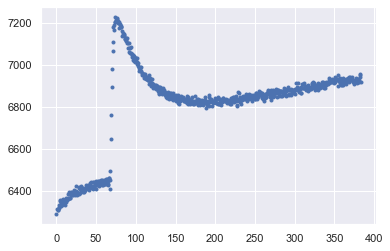

In [4]:
plt.scatter(df.loc[['Well'],], df.loc[['A1'],], marker='.')

In [5]:
# plot experiment N1 :: Fluoxetine 200 uM experiement

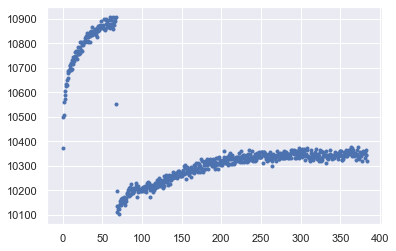

In [6]:
plt.scatter(df.loc[['Well'],], df.loc[['N1'],], marker='.')

In [7]:
# -------- Data analysis functions ------------------

In [8]:
def extract_plot_info(x, y, peak_height_min=None, peak_height_max=None, prominence_value = None, width=1):
    peaks, peaks_dict = find_peaks(y, height=(peak_height_min, peak_height_max),  # Min and max thresholds to detect peaks.
           threshold=None,  # Min and max vertical distance to neighboring samples.
           distance=None,  # Min horizontal distance between peaks.
           prominence=prominence_value,  # Vertical distance between the peak and lowest contour line.
           width=width,  # Min required width (in bins). E.g. For 10Khz, 10 bins = 1 ms.
           wlen=None,  # Window length to calculate prominence.
           rel_height=0.5,  # Relative height at which the peak width is measured.
           plateau_size=None)
    #print(f'peaks {peaks} \nPeak properties\n{peaks_dict}')
    fs = 720
    event_no = 0
    pretrigger_window = (2 * fs)/1000  # Pre-event time window in ms
    posttrigger_window = (5 * fs)/1000  # Post-event time window in ms
    # Create table with results
    table = pd.DataFrame(columns = ['event', 'peak_position', 
                                    'peak_position_s',
                                    'event_start', 'event_end',
                                    'Peak_Relative_light_units', 'Width_ms', 
                                    'inst_freq', 'isi_s', 
                                    'Area_Relative_light_units/ms', 'log_decay', 
                                    'tau_exp'])

    table.event = np.arange(1, len(peaks) + 1)
    table.peak_position = peaks
    table.peak_position_s = peaks / fs  # Divided by fs to get s
    table.event_start = peaks_dict['left_ips'] - pretrigger_window
    table.event_end = peaks_dict['right_ips'] + posttrigger_window
    table.Peak_Relative_light_units = peaks_dict['peak_heights']  # height parameter is needed
    table.Width_ms = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height

    # Calculations based on the parameters above
    table.inst_freq = np.append((1 / (np.array(table.peak_position[1:]) -
                                      np.array(peaks_dict['left_ips'][:-1])) * fs), 'nan')  
    table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
    # Calculations based on the parameters above
    table.inst_freq = np.append((1 / (np.array(table.peak_position[1:]) -
                                      np.array(peaks_dict['left_ips'][:-1])) * fs), 'nan')  
    table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
    # Area
    for i, event in table.iterrows():
        individual_event = y[int(event.event_start) : int(event.event_end)]
        table.loc[i, 'Area_Relative_light_units/ms'] = np.round(individual_event.sum(), 1)/(fs/1000)
   # Decay tau from logistic regression
    for i, event in table.iterrows():
        decay_tau = abs(y[int(event.peak_position) : int(event.event_end)])
        log_decay_tau = np.log(decay_tau)
        decay_width = int(len(decay_tau))
        decay_width_array = list(range(0, decay_width))
        slope, _ = np.polyfit(decay_width_array, log_decay_tau, 1)
        tau = -1 / slope
        table.loc[i, 'log_decay'] = tau/(fs/1000)
    # Decay tau from monoexponential fitting
    for i, event in table.iterrows():
        decay_tau = y[int(event.peak_position) : int(event.event_end)]
        decay_width = int(len(decay_tau))
        decay_width_array = list(range(0, decay_width))
        a_initial = 200
        b_initial = 0.1
        # popt: optimal values for the parameters, pcov: estimated covariance of popt
        popt, pcov = scf(lambda t, a, b: a * np.exp(b * t), 
                               decay_width_array, decay_tau, 
                               p0=(a_initial, b_initial), 
                               maxfev=1000)  # maxfev: number of iterations
        a = popt[0]  
        b = popt[1]      
        table.loc[i, 'tau_exp'] = abs((1/b)/(fs/1000))
        
    return table

In [9]:
def fit_curve(y, peak_start, peak_end):
    decay_tau = abs(y[int(peak_start):int(peak_end)])
    decay_width = int(len(decay_tau))
    
    # ---------- Curve fitting # 1. by log method -----------
    
    log_decay_tau = np.log(decay_tau)
    decay_width_array = list(range(0, decay_width))
    slope, intercept = np.polyfit(decay_width_array, log_decay_tau, 1)

    a_log = np.exp(intercept)
    b_log = slope
    x_fitted = np.linspace(np.min(decay_width_array), np.max(decay_width_array), decay_width)
    y_fitted = a_log * np.exp(b_log * x_fitted)

    # ---------- Curve fitting # 2. by exponential method -----------

    decay_tau = abs(y[int(peak_start):int(peak_end)])
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))

    a_initial = 0.1
    b_initial = 0.1
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = scf(lambda t, a, b: a * np.exp(b * t),
                           decay_width_array, decay_tau, p0=(a_initial, b_initial))
    a = popt[0]  # 
    b = popt[1]      
    x_fitted2 = np.linspace(np.min(decay_width_array), np.max(decay_width_array), decay_width)
    y_fitted2 = a * np.exp(b * x_fitted2)

    # Plot the log fitting
    fig = plt.figure(figsize=(5, 2))
    a_log = np.exp(intercept)
    b_log = slope
    x_fitted = np.linspace(np.min(decay_width_array), np.max(decay_width_array), decay_width)
    y_fitted = a_log * np.exp(b_log * x_fitted)
    ax1 = fig.add_subplot(221)
    ax1.set_title("Log method") 
    ax1.plot(decay_width_array, decay_tau, '--', color='green')
    ax1.plot(x_fitted, y_fitted, '--', color='red')
    ax1.set_ylabel("Relative light units")

    # Plot the exponential fitting
    ax2 = fig.add_subplot(222)
    ax2.plot(decay_width_array, decay_tau)
    ax2.plot(x_fitted2, y_fitted2)
    ax2.set_title("Exponential method") 
    fig.tight_layout()
    #plt.show()
    return fig

In [10]:
# run above functions on Control A1

In [11]:
temp_res_table_A1 = extract_plot_info(df.loc[['Well'],].values[0], df.loc[['A1'],].values[0], peak_height_min=100, peak_height_max=None, prominence_value = 100, width=10)
temp_res_table_A1

,event,peak_position,peak_position_s,event_start,event_end,Peak_Relative_light_units,Width_ms,inst_freq,isi_s,Area_Relative_light_units/ms,log_decay,tau_exp
0,1,140,0.194444,130.926279,195.285185,7230.0,82.38737,nan,0.0,641433.333333,2253.585687,2252.426195


In [12]:
# run above functions on Control A3

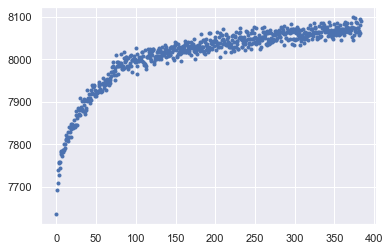

In [13]:
plt.scatter(df.loc[['Well'],], df.loc[['A3'],], marker='.')

In [14]:
temp_res_table_A3 = extract_plot_info(df.loc[['Well'],].values[0], df.loc[['A8'],].values[0], peak_height_min=None, peak_height_max=None, prominence_value = 50, width=1)
temp_res_table_A3

,event,peak_position,peak_position_s,event_start,event_end,Peak_Relative_light_units,Width_ms,inst_freq,isi_s,Area_Relative_light_units/ms,log_decay,tau_exp
0,1,311,0.431944,308.622500,315.850000,8012.0,3.038194,18.028169014084508,0.000000,77598.611111,593.000309,592.213341
1,2,350,0.486111,347.667143,355.183333,8022.0,3.439153,13.359840954274347,0.054167,88861.111111,2528.953088,2525.303319
2,3,403,0.559722,398.295294,407.454839,8037.0,5.721590,5.986793837123991,0.073611,100151.388889,756.835421,756.977634
3,4,520,0.722222,516.287273,524.443750,8066.0,4.328441,14.042553191489366,0.162500,89331.944444,852.846946,851.934957
4,5,569,0.790278,566.975094,574.219048,8073.0,3.061046,nan,0.068056,89366.666667,1380.829912,1378.241108


In [15]:
# ------------ Let's analyze N1- well :: Fluoxetine 200 uM experiement ---------

In [16]:
# 1. peak identification 

In [17]:
temp_res_table_N1 = extract_plot_info(df.loc[['Well'],].values[0], df.loc[['N1'],].values[0], peak_height_min=100, peak_height_max=None, prominence_value = 100, width=10)
temp_res_table_N1

,event,peak_position,peak_position_s,event_start,event_end,Peak_Relative_light_units,Width_ms,inst_freq,isi_s,Area_Relative_light_units/ms,log_decay,tau_exp
0,1,112,0.155556,9.024286,130.352113,10909.0,161.510871,6.231839258114374,0.000000,1815697.222222,525.427692,543.413825
1,2,126,0.175000,9.024286,130.352113,10909.0,161.510871,nan,0.019444,1815697.222222,54.530526,53.977136


In [18]:
# 2. curve fitting using peak parameters 

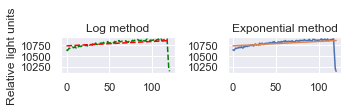

In [19]:
res_fig = fit_curve(df.loc[['N1'],].values[0], peak_start=9.024286, peak_end=130.352113)


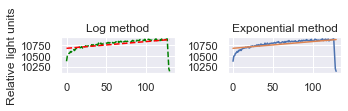

In [20]:
res_fig_1_05_130 = fit_curve(df.loc[['N1'],].values[0], peak_start=0, peak_end=130.352113)

In [21]:
# Code adpoted from
# https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/
# https://swharden.com/pyabf/tutorial/
# https://github.com/swharden/pyABF/tree/main/data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [ ]:
# The end